In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
fake=pd.read_csv("data/Fake.csv.zip")
true=pd.read_csv("data/True.csv.zip")

fake['label']=0
true['label']=1

df=pd.concat([fake,true],axis=0)
df=df.sample(frac=1,random_state=42).reset_index(drop=True)

df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [3]:
df.shape

(44898, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


BASIC DATA CLEANING

In [5]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [4]:
df['label'].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

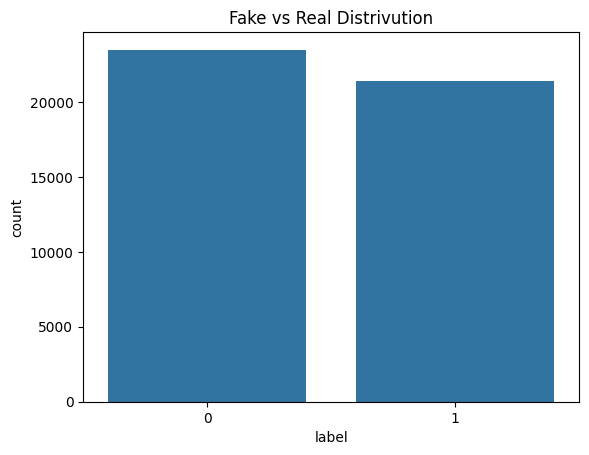

In [4]:
sns.countplot(x='label',data=df)
plt.title("Fake vs Real Distrivution")
plt.show()

In [5]:
df['content']=df['title']+ " "+ df['text']
df=df[['content','label']]
df.head()

,content,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1


TEXT PREPROCESSING

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Kanav
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Kanav
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
lemmatizer=WordNetLemmatizer()
stop_word=set(stopwords.words("english"))

def clean_text(text):
    text=text.lower()
    text=re.sub(r'[^a-zA-Z]', ' ', text)
    words=text.split()
    filter_word=[]
    for word in words:
        if word not in stop_word:
            filter_word.append(word)
    lemmatize_word=[]
    for word in filter_word:
        lemmatize_word.append(lemmatizer.lemmatize(word))
    
    return " ".join(lemmatize_word)

In [8]:
df['content']=df['content'].apply(clean_text)

Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X=df['content']
y=df['label']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)

(35918,)
(8980,)


Convert Text to Numbers (TF-IDF)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Training Model

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Evaluate Model

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9869710467706013

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4710
           1       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



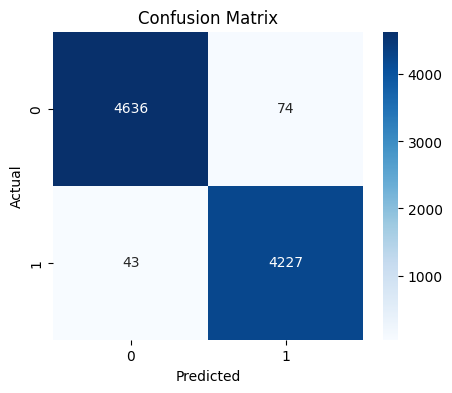

In [13]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Improve Model (SVM)

In [14]:
from sklearn.svm import LinearSVC
svm_model=LinearSVC()
svm_model.fit(X_train_tfidf,y_train)

y_pred_svm=svm_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Accuracy: 0.9939866369710467

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4710
           1       0.99      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Comparing Model

In [15]:
from sklearn.metrics import precision_score,recall_score,f1_score
result={
    "Model":["LogisticRegression","SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Percision": [
        precision_score(y_test, y_pred, ),
        precision_score(y_test, y_pred_svm, )
    ],
    "Recall": [
        recall_score(y_test, y_pred, ),
        recall_score(y_test, y_pred_svm, )
    ],
    "F1-Score": [
        f1_score(y_test, y_pred, ),
        f1_score(y_test, y_pred_svm, )
    ]
}
comparison_df = pd.DataFrame(result).set_index("Model")
comparison_df


,Accuracy,Percision,Recall,F1-Score
Model,,,,
LogisticRegression,0.986971,0.982795,0.989930,0.986349
SVM,0.993987,0.992754,0.994614,0.993683


In [16]:
def predict_news(news_text):
    
    # Step 1: Clean the text (IMPORTANT — same preprocessing)
    cleaned_text = clean_text(news_text)
    
    # Step 2: Convert to TF-IDF
    vectorized_text = vectorizer.transform([cleaned_text])
    
    # Step 3: Predict
    prediction = svm_model.predict(vectorized_text)
    
    # Step 4: Convert label to readable form
    if prediction[0] == 0:
        return "Fake News"
    else:
        return "Real News"


In [ ]:
sample_news ="The government announced a new economic reform plan to boost employment across the country."
print(predict_news(sample_news))


Fake News


In [22]:
sample_news = """
President Donald Trump was sworn in as the 45th President of the United States on January 20, 2017, following his victory in the 2016 presidential election. The inauguration ceremony took place at the U.S. Capitol in Washington, D.C., where Trump delivered his inaugural address outlining his administration’s priorities, including economic reform, immigration policy, and national security.
"""


print(predict_news(sample_news))

Real News
